In [268]:
import pandas as pd
import os
from glob import glob
import seaborn as sea
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt


`# Instructions
1. Create a new folder for your run. 
2. Before you drive, Save your VE table in that folder as 've.table'
3. Log your run (in ASCII format) as "log.msl"
4. Use thse functions to do things: 
    

In [269]:
def get_file(filename):

    with open(filename, errors = 'ignore') as f:
        data = f.read()
        
    data = data.split('\n')[2:]
    data = '\n'.join(data)
    with open('temp.csv', 'w') as f:
        f.write(data)
        
    data = pd.read_csv('temp.csv', sep = '\t', low_memory=False)
    dtypes = data.iloc[0]
    data = data.iloc[1:]
    
    for column in data.columns:
        try:
            data[column] = pd.to_numeric(data[column])
        except ValueError as e:
            pass
    data['Load'] = data['MAP']
    data['afr_target'] = data['AFR Target']
    data['Fuel: Accel enrich'] = data['Accel Enrich'] 
    data['true_target']  = data['afr_target'] * (1 - (data["Fuel: Accel enrich"]/100 - 1))
    data['error'] = data['AFR']- data['true_target']
    
    return data


In [270]:
def get_table(filename):
    

    tree = ET.parse(filename + '.table')
    
    
    for thing in tree.getiterator():
        if ('zValues' in thing.tag) and ('tableData' not in thing.tag):
            raw_data = thing.text

        if 'xAxis'in thing.tag:
            x_axis = thing.text
            x_axis = x_axis.strip().replace(' ', '').split('\n')
        if 'yAxis' in thing.tag:
            y_axis = thing.text
            y_axis = y_axis.strip().replace(' ', '').split('\n')


    rows = raw_data.strip().split('\n')
    raw_data_table = []

    for row in rows:
        vals = row.strip().split(' ')

        raw_data_table.append([float(x) for x in vals])

    data = pd.DataFrame(columns= [float(x) for x in x_axis], index= [float(y) for y in y_axis], data = raw_data_table )
    
    return data



In [271]:
def get_success_rate(folder):
    data = get_file(folder + '/log.msl')
    ve = get_table(folder+ '/ve')
    
    states = []
    for column in data.columns:
        if 'engine' in column.lower() and column != 'Engine':
            states.append(column)
    
    text= ['Positive is Lean, Negative is Rich']
    for state in states:
        temp = data[data[state] == 1]
        avg_error = round(temp['error'].mean(),2)
        samples = len(temp)
        text.append(f"Average Error: {avg_error} | samples: {samples} | {state}")
    
    avg_error = round(data['error'].mean(),2)
    avg_absolute_error = round(data['error'].apply(abs).mean(),2)
    
    text.append(f"AVERAGE ERROR {avg_error}")
    text.append(f"AVERAGE ABSOLUTE ERROR {avg_absolute_error}")
    text = '\n'.join(text)

    with open(folder+ '/stats.txt', 'w') as f:
        f.write(text)
        
    cols_to_chart = []
    for col in data.columns:
        if 'fuel' in col.lower():
            if 'cor' in col:
                cols_to_chart.append(col)
                
    cols_to_chart.append("CLT")
    for col in cols_to_chart:
        if len(data[col].value_counts())> 1:
            fig, ax = plt.subplots()
            fig.set_size_inches(8*1.3,8)
            data.set_index('Time')[col].plot()
            ax.set_title(col)
            plt.savefig(folder + '/'+col + '.png', facecolor='w')
            
            plt.close()
            
    
    return text



In [272]:
def get_factor(data, ve, function): # FOR ALL CELLS IN VE TABLE, DO A FUNCTION TO THE DATA SUPPLIED
    final = pd.DataFrame(index = ve.index, columns= ve.columns)
    start_rpm = 0
    
    for end_rpm in ve.columns: # Iterate through each RPM group
        start_load = 0
        
        for end_load in ve.index: # Iterate through each Load Group
            
            sample = data[(data['Load'] >= start_load) & (data['Load'] < end_load)]#Filter for Load
            if len(sample) > 0:
                sample = sample[(sample['RPM'] >= start_rpm) & (sample['RPM'] < end_rpm)] #Filter for RPM
                if len(sample) > 0:
                    result = function(sample)# Calculate on remaining data
                    final.loc[end_load, end_rpm] = result #Save result on table
            start_load = end_load #Move Load iterator forward
        start_rpm = end_rpm#Move RPM iterator forward once every load iterator has been hit for that RPM.
    return final

In [273]:

def calculate_predicted_ve_table(samples, errors,ve, avg_tgt_afr,  min_samples):
    # Remove Minimum Samples
    sample_mask = samples.copy()
    sample_mask[samples<= min_samples] = 0 
    sample_mask[samples > min_samples] = 1
    errors = errors * sample_mask


    # Calculate PCT that everything is off
    # errors are errors/avg_tgt to convert to pct. 
    # One is added so that we can multiply the ve table by it and scale it
    # fillna is so that unknown values are kept the same as original ve table.
    pred_ve = (1 + (errors/avg_tgt_afr) ).fillna(1) * ve
    
    # Clean up for paste to clipboard
    pred_ve = pred_ve.sort_index(ascending = False).apply(lambda x: round(x,1))
    print("RECCOMENDED VE TABLE ADDED TO CLIPBOARD")
    pred_ve.to_clipboard(index = False, header = False)
    
    # Return to regular ordering
    pred_ve = pred_ve.sort_index()
    return pred_ve

In [274]:
2/1.25


1.6

In [275]:
def get_suggestions_based_on(folder):
    data = get_file(folder + '/log.msl')
    ve = get_table(folder+ '/ve')
    
    # SPECIFIC FILTERS HERE - Use Drive Notes to determine________________________________________
    data = data[data['CLT'] > 150] # Ensure car is warmed up - General 

    data = data[(data["RPM"] > 1500) | (data['Load'] > 35)] # Avoid messing with IDLE - General
    data = data[data['Load'] > 45]
    #data = data[data['TPS'] > 3]
    #data = data[data['Engine in overrun'] != 1]  # Avoid  Overrun Tuning - General
    data['error'] = data['error'] 
    ################################################################______________________________
    
    # Calculate mean error:
    def get_avg_error(x):
        return x['error'].mean()* 0.85 # Reduce IMpact of errors over here
    errors = get_factor(data, ve, get_avg_error)
    
    #Scale errors by acceleration enrichment - 
    
    #Calculate count of samples
    samples = get_factor(data, ve, len)
    
    avg_tgt_afr = get_factor(data, ve, lambda x: x['afr_target'].mean()) # Errors are a pct of this.
    pred_ve = calculate_predicted_ve_table(samples,
                                           errors,
                                           ve,
                                           avg_tgt_afr,
                                           min_samples=3)
    
    
    ################ 
    return pred_ve

    

In [276]:
folder = 'apr_17_c'


In [277]:
print(get_success_rate(folder))

Positive is Lean, Negative is Rich
AVERAGE ERROR -1.6
AVERAGE ABSOLUTE ERROR 3.08


In [278]:
pred_ve = get_suggestions_based_on(folder)
ve = get_table(folder + '/ve')


change_map = (pred_ve - ve )/ve # As a percent of current position
change_map = (change_map + 1) * 100 # Proper PCT
change_map = change_map.sort_index(ascending= False)
change_map = change_map.apply(lambda x: round(x, 2))

RECCOMENDED VE TABLE ADDED TO CLIPBOARD


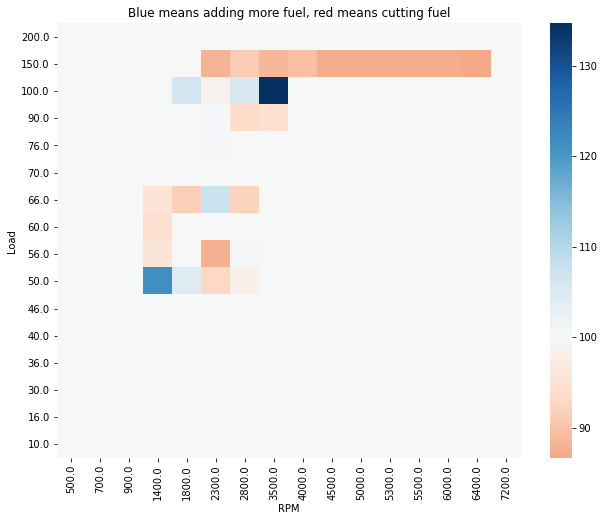

In [279]:

fig, ax = plt.subplots()
ax.set_title("Blue means adding more fuel, red means cutting fuel")
fig.set_size_inches(8*1.3, 8)
sea.heatmap(change_map, center = 100, cmap='RdBu')
ax.set_xlabel('RPM')
ax.set_ylabel("Load");
plt.savefig(folder + '/change_pic.png', facecolor='w')
            

In [280]:
data = get_file(folder + '/log.msl')
#data = data[data['CLT'] > 160]

In [281]:
x = data.corr()['CLT']

In [282]:
x = x.dropna()

In [283]:
data['AFR'].describe()

count    3010.000000
mean       12.002890
std         2.621906
min        10.000000
25%        10.300000
50%        10.500000
75%        12.700000
max        18.500000
Name: AFR, dtype: float64

<AxesSubplot:xlabel='Time'>

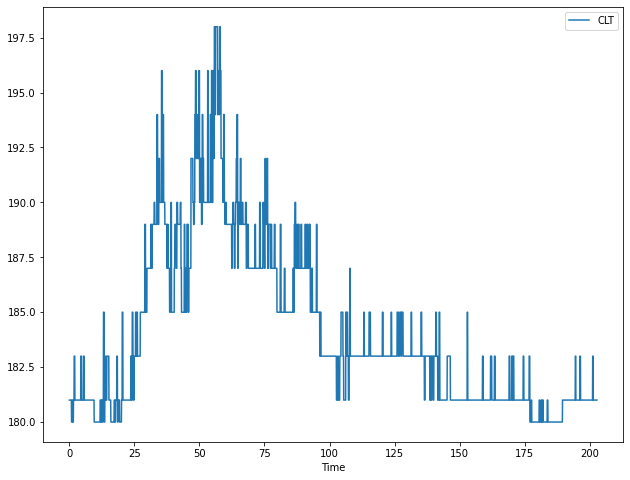

In [284]:
data = get_file(folder + '/log.msl')

fig, ax = plt.subplots()
fig.set_size_inches(8 * 1.3,8)

data.set_index('Time')[['CLT']].plot(ax = ax)

<AxesSubplot:xlabel='Load'>

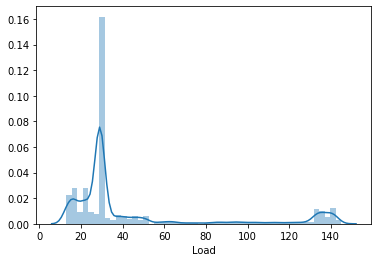

In [285]:
sea.distplot(data['Load'])

In [286]:
data = get_file(folder + '/log.msl')

data = data[data['CLT'] > 150] # Ensure car is warmed up - General 
data = data[(data["RPM"] > 700)] #| (data['Load'] > 30)] # Avoid messing with IDLE - General
data = data[data['TPS'] > 10]

/home/ryan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     7621.
Date:                Sat, 17 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:50:14   Log-Likelihood:                -2774.7
No. Observations:                 922   AIC:                             5555.
Df Residuals:                     919   BIC:                             5570.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Load           0.1985      0.005     40.368      0.000       0.189       0.208
RPM            0.0089      0.000     56.824      0.000       0.009       0.009
Constant     -24.1316      0.426    -56.628      0.000     -24.968     -23.295
==============================================================================
Omnibus:                        3.305   Durbin-Watson:                   0.251
Prob(Omnibus):                  0.192   Jarque-Bera (JB):                2.905
Skew:                          -0.057   Prob(JB):                        0.234
Kurtosis:                       2.750   Cond. No.                     9.80e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

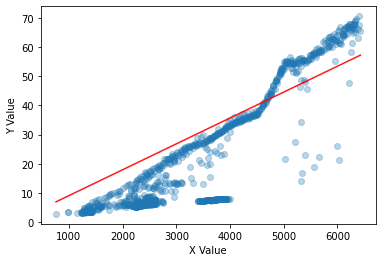

In [287]:
import numpy as np
from statsmodels import regression
import statsmodels.api as sm

X = data[['Load', 'RPM']]
X['Constant'] = 1

Y = data["DutyCycle1"].values

model = regression.linear_model.OLS(data['DutyCycle1'].values, X ).fit()


a = model.params[0]
b = model.params[1]
X = X['RPM']

# Return summary of the regression and plot results
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * b + a
plt.scatter(X, Y, alpha=0.3) # Plot the raw data
plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
plt.xlabel('X Value')
plt.ylabel('Y Value')
model.summary()

In [288]:

def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model.summary()

Text(0, 0.5, 'Duty Cycle')

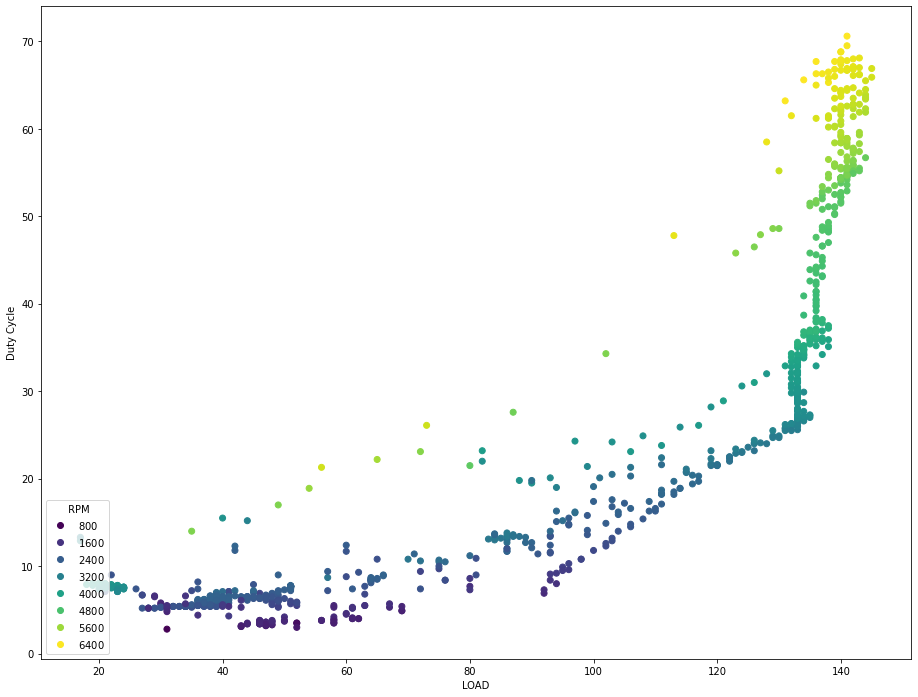

In [289]:
fig, ax = plt.subplots()
fig.set_size_inches(12 * 1.3,12 )
scatter = plt.scatter(data['Load'], data['DutyCycle1'], c = data['RPM'])
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title=" RPM")

ax.set_xlabel("LOAD")
ax.set_ylabel("Duty Cycle")

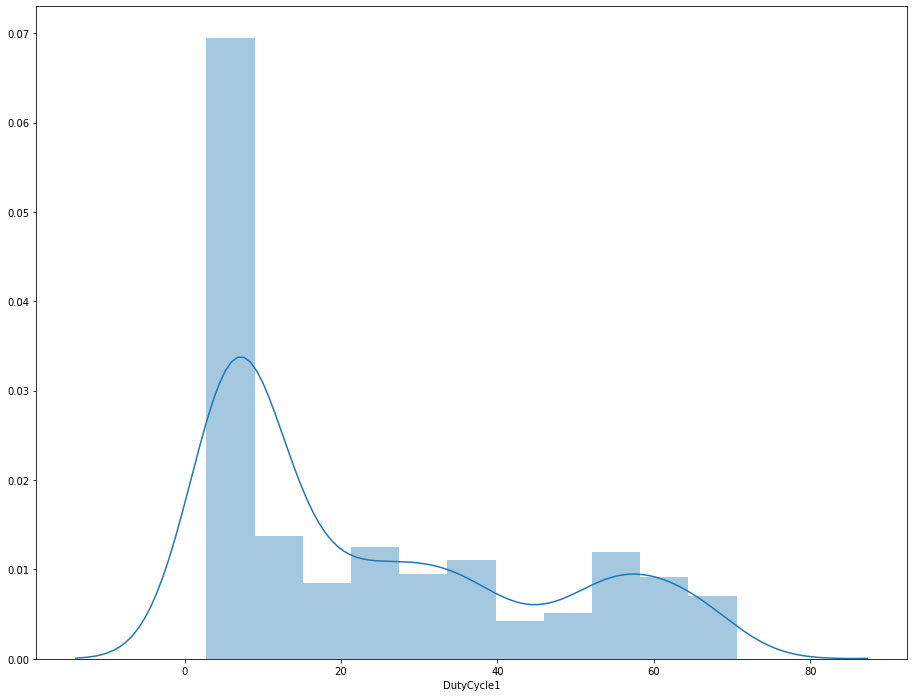

In [290]:
fig, ax = plt.subplots()
fig.set_size_inches(12 * 1.3,12 )
sea.distplot(data['DutyCycle1'], ax = ax)
plt.show()

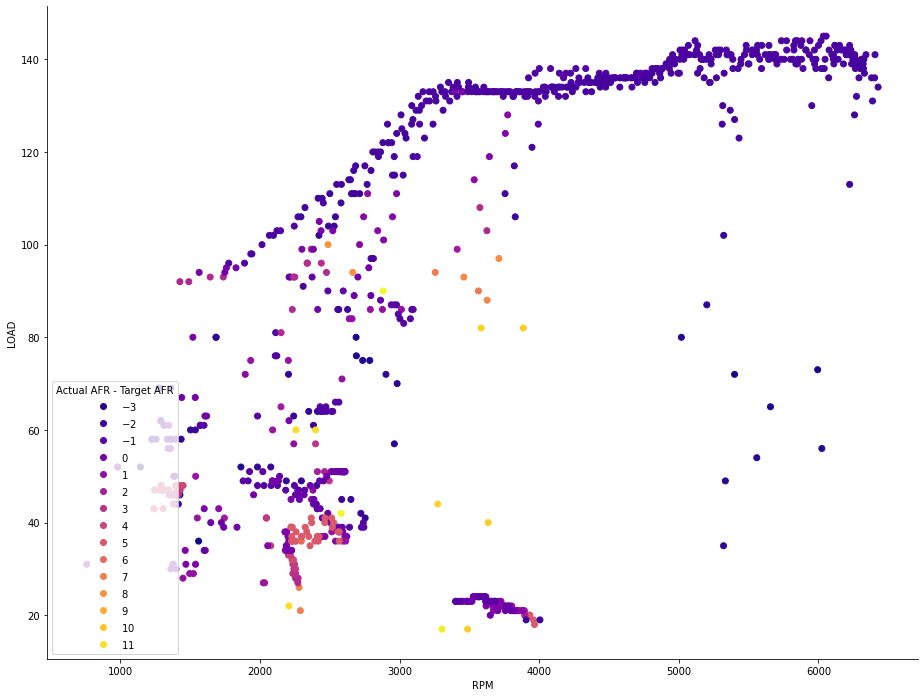

In [291]:
fig, ax = plt.subplots()
fig.set_size_inches(12 * 1.3,12 )

x = data['RPM']
y = data['Load']
hue = data['error']

scatter = plt.scatter(x, y, c = hue, cmap = 'plasma')
ax.set_xlabel("RPM")
ax.set_ylabel("LOAD")
sea.despine(ax = ax)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Actual AFR - Target AFR")



In [292]:
data.columns

Index(['Time', 'SecL', 'RPM', 'MAP', 'MAPxRPM', 'TPS', 'AFR', 'Lambda', 'IAT',
       'CLT', 'Engine', 'DFCO', 'Gego', 'Gair', 'Gbattery', 'Gwarm', 'Gbaro',
       'Gammae', 'Accel Enrich', 'Current VE', 'VE1', 'VE2', 'PW',
       'AFR Target', 'Lambda Target', 'PW2', 'DutyCycle1', 'DutyCycle2',
       'TPS DOT', 'Advance', 'Dwell', 'Battery V', 'rpm/s', 'Boost PSI',
       'Boost cut', 'Hard Launch', 'Hard Limiter', 'Idle Control', 'IAC value',
       'Baro Pressure', 'Sync Loss #', 'Aux0', 'Aux1', 'Aux2', 'Aux3', 'Aux4',
       'Aux5', 'Aux6', 'Aux7', 'Aux8', 'Aux9', 'Aux10', 'Aux11', 'Aux12',
       'Aux13', 'Aux14', 'Aux15', 'Advance 1', 'Advance 2', 'Load',
       'afr_target', 'Fuel: Accel enrich', 'true_target', 'error'],
      dtype='object')

<AxesSubplot:>

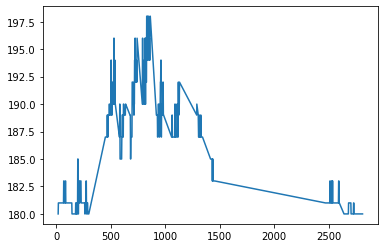

In [293]:
data['CLT'].plot()